Dataset yang digunakan: https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset

Dataset berisi list movie, rating, id movie pada imbd tmbd, dan tag

#### Mengunduh Dataset yang Digunakan

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [3]:
! kaggle datasets download -d shubhammehta21/movie-lens-small-latest-dataset

  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 160MB/s]


In [4]:
! unzip /content/movie-lens-small-latest-dataset.zip

Archive:  /content/movie-lens-small-latest-dataset.zip
  inflating: README.txt              
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


#### Import Library yang Dibutuhkan

In [5]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px

#### Import Data dan Melakukan EDA

In [6]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Memisahkan data pada fitur genre karena satu data memiliki banyak genre

In [8]:
movies['genres'] = pd.DataFrame(movies['genres'].str.replace('|', ',', regex=True))

Memasukkan data dengan genre yang sudah terpisah satu-satu kedalam variabel baru

In [9]:
genres_data = (movies.set_index(movies.columns.drop('genres',1).tolist())['genres']
               .str.split(',', expand=True)
               .stack()
               .reset_index()
               .rename(columns={0:'genres'})
               .loc[:, movies.columns]
               )

Menampilkan visualisasi banyaknya genre dalam dataset

In [10]:
fig = px.pie(genres_data, names = "genres",
             title = "<b>Counts in Genres</b>",             
             color_discrete_sequence=px.colors.sequential.Blackbody_r,             
             hole = 0.5)

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))

fig.update_traces(textposition='inside',
                  textinfo='percent+label',    
                  textfont_size=15,                  
                  marker=dict(line=dict(color='#000000', width = 1.5)))


fig.show()

In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


#### Preprocessing
Mengecek nilai null pada tiap data

In [12]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [13]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Menghilangkan duplikasi judul yang ada pada film

In [14]:
# Drop duplicate of movie

movies = movies.drop_duplicates('title')
len(movies)

9737

#### Content Based Filtering

In [15]:
data = movies
data.sample(5)

,movieId,title,genres
2819,3767,Missing in Action 2: The Beginning (1985),"Action,War"
1776,2374,Gung Ho (1986),"Comedy,Drama"
3747,5220,Showtime (2002),"Action,Comedy"
9254,155892,Me Him Her (2015),Comedy
433,496,What Happened Was... (1994),"Comedy,Drama,Romance,Thriller"


Mengambil fitur genre menggunakan tfidfvectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
tf = TfidfVectorizer()
tf.fit(data['genres']) 
tf.get_feature_names() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'fi',
 'film',
 'genres',
 'horror',
 'imax',
 'listed',
 'musical',
 'mystery',
 'no',
 'noir',
 'romance',
 'sci',
 'thriller',
 'war',
 'western']

Melakukan fit yang ditransformasi ke dalam bentuk matrix

In [17]:
tfidf_matrix = tf.fit_transform(data['genres']) 

tfidf_matrix.shape 

(9737, 24)

Mengubah vektor tfidf kedalam bentuk matriks

In [18]:
tfidf_matrix.todense()

matrix([[0.        , 0.41683543, 0.51622956, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51235123, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.57866302, 0.        , 0.81556674, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Menampilkan film dengan genrenya

In [19]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index=data.title
).sample(22, axis=1).sample(10, axis=0)

,fi,documentary,listed,comedy,mystery,imax,adventure,crime,children,action,...,western,genres,musical,fantasy,no,thriller,sci,romance,noir,war
title,,,,,,,,,,,,,,,,,,,,,
Alice Through the Looking Glass (2016),0.00000,0.0,0.0,0.000000,0.0,0.0,0.512351,0.000000,0.620531,0.000000,...,0.000000,0.0,0.0,0.593664,0.0,0.000000,0.00000,0.000000,0.0,0.0
Pandorum (2009),0.52414,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.419322,0.52414,0.000000,0.0,0.0
"Mod Squad, The (1999)",0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.756793,0.000000,0.653655,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0
"Fox and the Hound, The (1981)",0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.661502,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0
Even Cowgirls Get the Blues (1993),0.00000,0.0,0.0,0.570679,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.821173,0.0,0.0
Stuart Little 3: Call of the Wild (2005),0.00000,0.0,0.0,0.294386,0.0,0.0,0.000000,0.000000,0.555399,0.000000,...,0.000000,0.0,0.0,0.531352,0.0,0.000000,0.00000,0.000000,0.0,0.0
The Gambler (2014),0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.695669,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.593006,0.00000,0.000000,0.0,0.0
Porky's Hare Hunt (1938),0.00000,0.0,0.0,0.347501,0.0,0.0,0.000000,0.000000,0.655608,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0
3:10 to Yuma (1957),0.00000,0.0,0.0,0.000000,0.0,0.0,0.420969,0.000000,0.000000,0.369909,...,0.700264,0.0,0.0,0.000000,0.0,0.365073,0.00000,0.000000,0.0,0.0


Menghitung cosine similarity pada matrix tf-idf

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.81357359, 0.15270879, ..., 0.        , 0.42101966,
        0.2675912 ],
       [0.81357359, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15270879, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57067944],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42101966, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.2675912 , 0.        , 0.57067944, ..., 0.        , 0.        ,
        1.        ]])

Membuat dataframe cosine_sim dengan baris dan kolom berupa judul film serta melihat kesamaan data pada tiap film

In [21]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)
 
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9737, 9737)


title,Cowboy Bebop: The Movie (Cowboy Bebop: Tengoku no Tobira) (2001),Return to Me (2000),Closer to the Moon (2013),"Getaway, The (1972)",Black Dynamite (2009)
title,,,,,
Hellraiser III: Hell on Earth (1992),0.000000,0.000000,0.000000,0.000000,0.000000
"Child, The (L'enfant) (2005)",0.000000,0.272002,0.341652,0.690189,0.000000
Scary Movie 3 (2003),0.000000,0.000000,0.374323,0.000000,0.300596
Dune (1984),0.552125,0.000000,0.000000,0.000000,0.000000
Sixteen Candles (1984),0.000000,0.691058,0.419221,0.000000,0.336651
Sorority House Massacre II (1990),0.000000,0.000000,0.000000,0.000000,0.000000
Pulse (Kairo) (2001),0.172531,0.000000,0.000000,0.235170,0.000000
I Saw the Devil (Akmareul boatda) (2010),0.241917,0.000000,0.000000,0.783552,0.000000
"Little Shop of Horrors, The (1960)",0.000000,0.000000,0.374323,0.000000,0.300596


Membuat fungsi movie_recommendations

In [22]:
def movie_recommendations(movie_title, similarity_data=cosine_sim_df, items=data[['title', 'genres']], k=5):
    index = similarity_data.loc[:,movie_title].to_numpy().argpartition(
        range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(movie_title, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

Membuat fungsi untuk memvisualisasikan data rekomendasi ke dalam bentuk tabel

In [23]:
def render_predict_table(data, col_width=7.0, row_height=0.5, font_size=12,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    predict_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    predict_table.auto_set_font_size(False)
    predict_table.set_fontsize(font_size)

    for k, cell in predict_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [24]:
data[data.title.eq('Jungle Book, The (1967)')]

,movieId,title,genres
1543,2078,"Jungle Book, The (1967)","Animation,Children,Comedy,Musical"


Hasil Prediksi

In [25]:
movie_recommendations('Jungle Book, The (1967)')

,title,genres
0,Ferngully: The Last Rainforest (1992),"Animation,Children,Comedy,Musical"
1,"All Dogs Christmas Carol, An (1998)","Animation,Children,Comedy,Musical"
2,Alvin and the Chipmunks: The Squeakquel (2009),"Animation,Children,Comedy,Musical"
3,Steamboat Willie (1928),"Animation,Children,Comedy,Musical"
4,"Claymation Christmas Celebration, A (1987)","Animation,Children,Comedy,Musical"


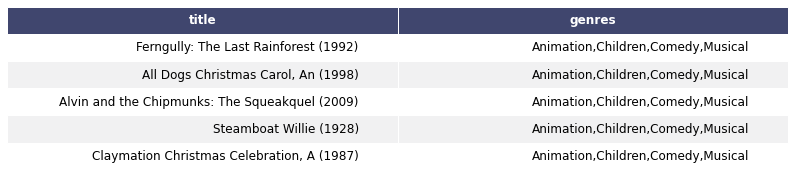

In [26]:
fig,ax = render_predict_table(pd.DataFrame(movie_recommendations('Jungle Book, The (1967)')), header_columns=0, col_width=7)
fig.savefig("table_predict.png")

In [27]:
data[data.title.eq('Alvin and the Chipmunks: The Squeakquel (2009)')]

,movieId,title,genres
7216,73042,Alvin and the Chipmunks: The Squeakquel (2009),"Animation,Children,Comedy,Musical"


In [28]:
movie_recommendations('Alvin and the Chipmunks: The Squeakquel (2009)')

,title,genres
0,Ferngully: The Last Rainforest (1992),"Animation,Children,Comedy,Musical"
1,"Jungle Book, The (1967)","Animation,Children,Comedy,Musical"
2,"All Dogs Christmas Carol, An (1998)","Animation,Children,Comedy,Musical"
3,Steamboat Willie (1928),"Animation,Children,Comedy,Musical"
4,"Claymation Christmas Celebration, A (1987)","Animation,Children,Comedy,Musical"


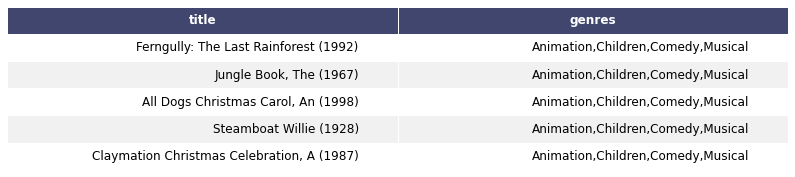

In [29]:
fig,ax = render_predict_table(pd.DataFrame(movie_recommendations('Alvin and the Chipmunks: The Squeakquel (2009)')), header_columns=0, col_width=7)
fig.savefig("table_predict.png")

In [30]:
data[data.title.eq('Conjuring, The (2013)')]

,movieId,title,genres
8218,103688,"Conjuring, The (2013)","Horror,Thriller"


In [31]:
movie_recommendations('Conjuring, The (2013)')

,title,genres
0,"Serbian Film, A (Srpski film) (2010)","Horror,Thriller"
1,Cursed (2005),"Horror,Thriller"
2,In Dreams (1999),"Horror,Thriller"
3,Tormented (1960),"Horror,Thriller"
4,Vacancy (2007),"Horror,Thriller"


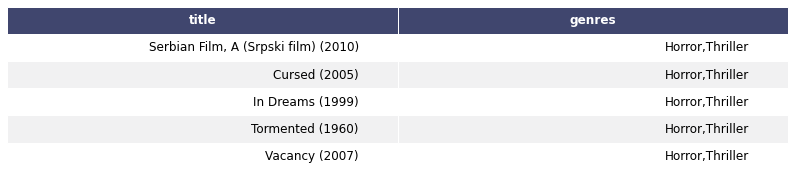

In [32]:
fig,ax = render_predict_table(pd.DataFrame(movie_recommendations('Conjuring, The (2013)')), header_columns=0, col_width=7)
fig.savefig("table_predict.png")

#### Collaborative Filtering

In [33]:
df = ratings
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Encoding data user

In [34]:
user_ids = df['userId'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

Encoding data movie

In [35]:
movie_ids = df['movieId'].unique().tolist()
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

Mapping data user dan movie

In [36]:
df['user'] = df['userId'].map(user_to_user_encoded)
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

In [37]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


Menampilkan jumlah user dan movie, serta mengubah nilai rating menjadi bentuk float

In [38]:
num_users = len(user_to_user_encoded)
print(num_users)

num_movie = len(movie_encoded_to_movie)
print(num_movie)

df['rating'] = df['rating'].values.astype(np.float32)

610
9724


In [39]:
min_rating = min(df['rating'])
max_rating = max(df['rating'])
 
print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0


In [40]:
df = df.sample(frac=1, random_state=57)
df

,userId,movieId,rating,timestamp,user,movie
63136,414,2433,2.0,961436616,413,2576
57907,380,91500,3.0,1494708626,379,1067
71638,462,1261,4.0,1138343577,461,1108
92518,597,2505,2.0,940420065,596,2579
34595,232,53127,0.5,1209068728,231,5962
...,...,...,...,...,...,...
19064,122,86833,5.0,1461562287,121,3484
85071,552,3751,4.5,1112151337,551,1186
35845,243,485,3.0,837155479,242,647
11990,73,112290,3.5,1464282984,72,2537


Melakukan train dan test split

In [41]:
x = df[['user', 'movie']].values
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[ 413 2576]
 [ 379 1067]
 [ 461 1108]
 ...
 [ 242  647]
 [  72 2537]
 [ 241  530]] [0.33333333 0.55555556 0.77777778 ... 0.55555556 0.66666667 0.77777778]


Membuat class RecommenderNet

In [42]:
import tensorflow as tf

class RecommenderNet(tf.keras.Model):
  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( #layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )

    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    movie_vector = self.movie_embedding(inputs[:, 1])
    movie_bias = self.movie_bias(inputs[:, 1])
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

Inisialisasi model dan melakukan compile

In [43]:
model = RecommenderNet(num_users, num_movie, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [44]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 25,
    validation_data = (x_val, y_val)
)

Epoch 1/25
2521/2521 [==============================] - 21s 5ms/step - loss: 0.6867 - root_mean_squared_error: 0.2798 - val_loss: 0.6781 - val_root_mean_squared_error: 0.2721
Epoch 2/25
2521/2521 [==============================] - 11s 4ms/step - loss: 0.6519 - root_mean_squared_error: 0.2471 - val_loss: 0.6424 - val_root_mean_squared_error: 0.2377
Epoch 3/25
2521/2521 [==============================] - 12s 5ms/step - loss: 0.6291 - root_mean_squared_error: 0.2244 - val_loss: 0.6322 - val_root_mean_squared_error: 0.2274
Epoch 4/25
2521/2521 [==============================] - 11s 4ms/step - loss: 0.6252 - root_mean_squared_error: 0.2204 - val_loss: 0.6293 - val_root_mean_squared_error: 0.2243
Epoch 5/25
2521/2521 [==============================] - 13s 5ms/step - loss: 0.6218 - root_mean_squared_error: 0.2170 - val_loss: 0.6260 - val_root_mean_squared_error: 0.2210
Epoch 6/25
2521/2521 [==============================] - 13s 5ms/step - loss: 0.6190 - root_mean_squared_error: 0.2141 - val_l

Plotting hasil RMSE data train dan test

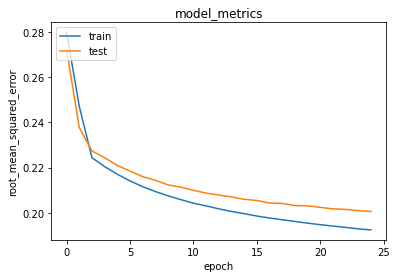

In [45]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Mengambil sampel untuk dilakukan prediksi film rekomendasi

In [46]:
movie_df = movies
df = pd.read_csv('ratings.csv')

user_id = df.userId.sample(5).iloc[0]
movie_watched_by_user = df[df.userId == user_id]
 
movie_not_watched = movie_df[~movie_df['movieId'].isin(movie_watched_by_user.movieId.values)]['movieId'] 
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

Menampilkan hasil dari sistem rekomendasi dengan teknik *collaborative filtering*

In [47]:
ratings = model.predict(user_movie_array).flatten()
 
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('---' * 9)
print('Movie with high ratings from users: {}'.format(user_id))
print('---' * 9)
 
top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)
 
movie_df_rows = movie_df[movie_df['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres)
 
print('----' * 8)
print('Top 5 movie recommendation for users: {} '.format(user_id))
print('----' * 8)
 
recommended_movie = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)

---------------------------
Movie with high ratings from users: 594
---------------------------
Three Musketeers, The (1993) : Action,Adventure,Comedy,Romance
Terminator 2: Judgment Day (1991) : Action,Sci-Fi
Terminator, The (1984) : Action,Sci-Fi,Thriller
Serendipity (2001) : Comedy,Romance
Chasing Liberty (2004) : Comedy,Romance
--------------------------------
Top 5 movie recommendation for users: 594 
--------------------------------
Star Wars: Episode V - The Empire Strikes Back (1980) : Action,Adventure,Sci-Fi
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action,Adventure
Goodfellas (1990) : Crime,Drama
Cool Hand Luke (1967) : Drama
Young Frankenstein (1974) : Comedy,Fantasy
